In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile,is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [3]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [4]:
comp = [
     'England'
     #'France',
     #'Germany',
     #'Italy',
     #'Spain'
]

In [5]:
##DA qui

In [6]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [7]:
selected_competitions = competitions[(competitions['country_name'] =='England')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
1,364,181150,England,English first division,male,2017/2018


### Append home and away goals to the game dataset

In [8]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [9]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [10]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181150,2500089,"Burnley - AFC Bournemouth, 1 - 2",364,1,2
1,181150,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",364,2,0
2,181150,2500091,"Huddersfield Town - Arsenal, 0 - 1",364,0,1
3,181150,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0",364,4,0
4,181150,2500093,"Manchester United - Watford, 1 - 0",364,1,0


In [11]:
# Get games from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,38,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,38,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,38,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,38,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,38,1611,1644


In [12]:
#Append goals to each match
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [13]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,1646,1659,2018-05-13 14:00:00,1,2
1,1628,1627,2018-05-13 14:00:00,2,0
2,1673,1609,2018-05-13 14:00:00,0,1
3,1612,1651,2018-05-13 14:00:00,4,0
4,1611,1644,2018-05-13 14:00:00,1,0
...,...,...,...,...,...
375,1623,1639,2017-08-12 14:00:00,1,0
376,1619,10531,2017-08-12 14:00:00,0,0
377,1627,1659,2017-08-12 14:00:00,1,0
378,1644,1612,2017-08-12 11:30:00,3,3


### Convert event to actions

In [14]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Eng"

In [15]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [16]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,1646,Burnley,Burnley FC
1,1659,AFC Bournemouth,AFC Bournemouth
2,1628,Crystal Palace,Crystal Palace FC
3,1627,West Bromwich Albion,West Bromwich Albion FC
4,1609,Arsenal,Arsenal FC
5,1673,Huddersfield Town,Huddersfield Town FC
6,1651,Brighton & Hove Albion,Brighton & Hove Albion FC
7,1612,Liverpool,Liverpool FC
8,1644,Watford,Watford FC
9,1611,Manchester United,Manchester United FC


In [17]:
#Select a game
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "England") 
                  & (games.home_team_name_short == "Brighton & Hove Albion")
                  & (games.away_team_name_short== "Liverpool")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[593:599]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
593,2499861,211308775,593,1,1152.165458,1612,120353,14.7,38.76,0.0,0.00,23,0,receival,foot,Mohamed Salah,Liverpool,Liverpool FC
594,2499861,211308776,594,1,1152.648785,1612,120353,14.7,38.76,6.3,-17.68,0,0,pass,foot,Mohamed Salah,Liverpool,Liverpool FC
595,2499861,211308776,595,1,1153.605692,1612,3802,21.0,21.08,0.0,0.00,23,0,receival,foot,Philippe Coutinho,Liverpool,Liverpool FC
596,2499861,211308777,596,1,1154.562600,1612,3802,21.0,21.08,-14.7,-8.84,0,0,pass,foot,Philippe Coutinho,Liverpool,Liverpool FC
597,2499861,211308777,597,1,1156.022010,1612,222220,6.3,12.24,0.0,0.00,23,0,receival,foot,A. Robertson,Liverpool,Liverpool FC
598,2499861,211308778,598,1,1157.481420,1612,222220,6.3,12.24,-2.1,34.68,1,0,cross,foot,A. Robertson,Liverpool,Liverpool FC


In [18]:
games[games.game_id ==2499861].drop(['season_id','country_name','competition_gender','home_team_name_short','away_team_name_short','season_name'], axis = 1).reset_index(drop = True)

,game_id,competition_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score,competition_name,home_team_name,away_team_name
0,2499861,364,2017-12-02 15:00:00,15,1651,1612,1,5,English first division,Brighton & Hove Albion FC,Liverpool FC


In [19]:
atomic_actions[594:599].drop(['original_event_id','team_name_short'], axis = 1).reset_index(drop = True)

,game_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name
0,2499861,594,1,1152.648785,1612,120353,14.7,38.76,6.3,-17.68,0,0,pass,foot,Mohamed Salah,Liverpool FC
1,2499861,595,1,1153.605692,1612,3802,21.0,21.08,0.0,0.00,23,0,receival,foot,Philippe Coutinho,Liverpool FC
2,2499861,596,1,1154.562600,1612,3802,21.0,21.08,-14.7,-8.84,0,0,pass,foot,Philippe Coutinho,Liverpool FC
3,2499861,597,1,1156.022010,1612,222220,6.3,12.24,0.0,0.00,23,0,receival,foot,A. Robertson,Liverpool FC
4,2499861,598,1,1157.481420,1612,222220,6.3,12.24,-2.1,34.68,1,0,cross,foot,A. Robertson,Liverpool FC


2017-12-02 15:00:00, Brighton & Hove Albion FC - Liverpool FC : 1-5 , Roberto Firmino 48'


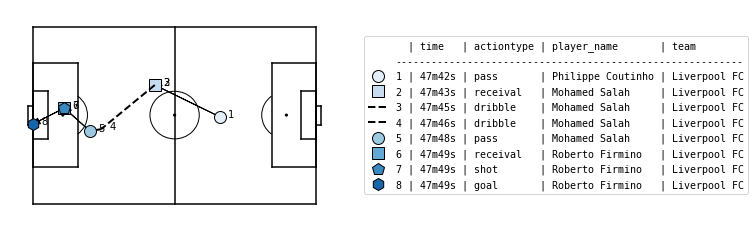

In [20]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [21]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [22]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [23]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y


Computing and storing labels in /Users/leonardoyang/Desktop/data-fifa/Eng/atomic_labels.h5: 100%|██████████| 380/380 [00:57<00:00,  6.65it/s]


### Compute Probabilities

In [24]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [25]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.movement_polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

## Model 

In [26]:
### load model 
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

In [27]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:03<00:00, 97.90it/s] 


In [28]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:08<00:00, 45.65it/s]


## VAEP

In [29]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [30]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:24<00:00, 15.22it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [31]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [32]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "Team","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
392,120353,Mohamed Salah,Forward,Liverpool,38.074385,37.383939,0.690446,2836
185,8717,H. Kane,Forward,Tottenham Hotspur,35.214978,34.535301,0.679678,2128
340,61390,M. Ryan,Goalkeeper,Brighton & Hove Albion,29.807561,2.661488,27.146073,1996
71,7905,R. Lukaku,Forward,Manchester United,26.053293,25.681763,0.371531,1828
143,8325,S. Agüero,Forward,Manchester City,25.663223,25.472139,0.191084,1780
4,54,C. Eriksen,Midfielder,Tottenham Hotspur,24.698155,21.841608,2.856547,5416
244,12829,J. Vardy,Forward,Leicester City,23.401707,23.367064,0.034644,1420
237,11066,R. Sterling,Forward,Manchester City,23.392714,22.969587,0.423126,3134
325,38021,K. De Bruyne,Midfielder,Manchester City,23.366588,21.408197,1.958392,6545
108,8094,J. Butland,Goalkeeper,Stoke City,23.265653,3.056390,20.209263,2170


In [33]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1200] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
391,120353,Mohamed Salah,Forward,Liverpool,38.074385,37.383939,0.690446,2836,3065,1.118008,1.097734,0.020274
142,8325,S. Agüero,Forward,Manchester City,25.663223,25.472139,0.191084,1780,2096,1.101951,1.093746,0.008205
184,8717,H. Kane,Forward,Tottenham Hotspur,35.214978,34.535301,0.679678,2128,3257,0.973088,0.954307,0.018781
469,340386,Gabriel Jesus,Forward,Manchester City,17.846282,17.784943,0.061339,1455,1774,0.905392,0.902280,0.003112
398,134513,A. Martial,Forward,Manchester United,15.952273,14.667723,1.284550,2022,1684,0.852556,0.783904,0.068652
257,14911,Son Heung-Min,Forward,Tottenham Hotspur,20.847098,20.129217,0.717880,2550,2424,0.774026,0.747372,0.026654
288,25413,A. Lacazette,Forward,Arsenal,20.021740,19.759096,0.262644,1763,2331,0.773040,0.762899,0.010141
70,7905,R. Lukaku,Forward,Manchester United,26.053293,25.681763,0.371531,1828,3055,0.767527,0.756582,0.010945
26,3319,M. Özil,Midfielder,Arsenal,19.559379,18.277414,1.281965,4213,2295,0.767034,0.716761,0.050273
236,11066,R. Sterling,Forward,Manchester City,23.392714,22.969587,0.423126,3134,2751,0.765301,0.751459,0.013843


In [34]:
copy = stats.sort_values("vaep_rating",ascending=False)[:10].copy()
copy[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
391,Mohamed Salah,Forward,Liverpool,1.118008
142,S. Agüero,Forward,Manchester City,1.101951
184,H. Kane,Forward,Tottenham Hotspur,0.973088
469,Gabriel Jesus,Forward,Manchester City,0.905392
398,A. Martial,Forward,Manchester United,0.852556
257,Son Heung-Min,Forward,Tottenham Hotspur,0.774026
288,A. Lacazette,Forward,Arsenal,0.773040
70,R. Lukaku,Forward,Manchester United,0.767527
26,M. Özil,Midfielder,Arsenal,0.767034
236,R. Sterling,Forward,Manchester City,0.765301


In [35]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Goalkeeper'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
339,M. Ryan,Goalkeeper,Brighton & Hove Albion,0.741072
107,J. Butland,Goalkeeper,Stoke City,0.621522
45,Adrián,Goalkeeper,West Ham United,0.602468
95,R. Elliot,Goalkeeper,Newcastle United,0.580665
127,Gomes,Goalkeeper,Watford,0.567349
337,J. Lössl,Goalkeeper,Huddersfield Town,0.535607
233,J. Pickford,Goalkeeper,Everton,0.535439
55,Ł. Fabiański,Goalkeeper,West Ham United,0.526674
64,P. Čech,Goalkeeper,Arsenal,0.511401
241,N. Pope,Goalkeeper,Burnley,0.509581


In [36]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Defender'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
21,P. van Aanholt,Defender,Crystal Palace,0.597751
57,L. Koscielny,Defender,Arsenal,0.434906
43,Nacho Monreal,Defender,Arsenal,0.415888
103,Marcos Alonso,Defender,Chelsea,0.393314
12,D. Janmaat,Defender,Watford,0.368733
255,J. Matip,Defender,Liverpool,0.360493
84,A. Valencia,Defender,Manchester United,0.359792
113,J. Stephens,Defender,Southampton,0.344522
136,V. Kompany,Defender,Manchester City,0.342364
415,A. Robertson,Defender,Liverpool,0.337302


In [37]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Midfielder'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
26,M. Özil,Midfielder,Arsenal,0.767034
139,David Silva,Midfielder,Manchester City,0.750827
82,J. Lingard,Midfielder,Manchester United,0.704276
61,A. Ramsey,Midfielder,Arsenal,0.687562
154,W. Zaha,Midfielder,Crystal Palace,0.672803
3,C. Eriksen,Midfielder,Tottenham Hotspur,0.652049
324,K. De Bruyne,Midfielder,Manchester City,0.642724
428,L. Sané,Midfielder,Manchester City,0.597760
62,J. Wilshere,Midfielder,West Ham United,0.565842
385,Willian,Midfielder,Chelsea,0.565542


In [38]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Forward'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
391,Mohamed Salah,Forward,Liverpool,1.118008
142,S. Agüero,Forward,Manchester City,1.101951
184,H. Kane,Forward,Tottenham Hotspur,0.973088
469,Gabriel Jesus,Forward,Manchester City,0.905392
398,A. Martial,Forward,Manchester United,0.852556
257,Son Heung-Min,Forward,Tottenham Hotspur,0.774026
288,A. Lacazette,Forward,Arsenal,0.773040
70,R. Lukaku,Forward,Manchester United,0.767527
236,R. Sterling,Forward,Manchester City,0.765301
248,M. Arnautović,Forward,West Ham United,0.753880


In [42]:
df = pd.merge(giocatori,eng, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df[df['Player'].isna()].sort_values(['Team','vaep_value'], ascending = [True,False])

KeyError: 'Team'

### Salary

In [45]:
eng = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/premier-league/2017-2018/all_premier-league_2017-2018.xlsx')
eng["Annual Gross(IN EUR)"] = eng["Annual Gross(IN GBP)"]*1.14
eng = eng[eng["Annual Gross(IN EUR)"]>0]
eng = eng.drop_duplicates(subset=["Player"], keep='last')
eng.drop('Unnamed: 0', axis = 1, inplace = True)
eng['Name'] = [eng['Player'][i-1:i].values[0].split()[0] for i in range(1,len(eng.Player)+1)]
eng['Surname'] = [eng['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(eng.Player)+1)]

players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
giocatori = giocatori[giocatori['minutes_played']>1200]

df = pd.merge(giocatori,eng, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,eng, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop('player_id', axis = 1)
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean()

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,25.8,14.177415,13.46506,0.712355,1777.6,2223.65,0.552778,5060488.5,0.037645


In [46]:
display(eng[eng['Role']=='D'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])
display(eng[eng['Role']=='F'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])

,ID,Player,Annual Gross(IN GBP),Adj. Gross(IN GBP),Role,Age,Country,Team,League,Season,Annual Gross(IN EUR),Name,Surname
388,NaN,Nicolás Otamendi,9360000,9616912,D,29,Argentina,Manchester City,Premier League,2017-2018,10670400.0,Nicolás,Otamendi
490,NaN,Virgil van Dijk,9360000,9616912,D,25,Netherlands,Southampton,Premier League,2017-2018,10670400.0,Virgil,Dijk
394,NaN,Vincent Kompany,7800000,8014094,D,31,Belgium,Manchester City,Premier League,2017-2018,8892000.0,Vincent,Kompany
393,NaN,Aymeric Laporte,7800000,8014094,D,23,France,Manchester City,Premier League,2017-2018,8892000.0,Aymeric,Laporte
153,NaN,David Luiz,6490000,6668137,D,30,Brazil,Chelsea,Premier League,2017-2018,7398600.0,David,Luiz


,ID,Player,Annual Gross(IN GBP),Adj. Gross(IN GBP),Role,Age,Country,Team,League,Season,Annual Gross(IN EUR),Name,Surname
418,NaN,Alexis Sánchez,18200000,18699552,F,28,Chile,Manchester United,Premier League,2017-2018,20748000.0,Alexis,Sánchez
149,NaN,Eden Hazard,11589000,11907094,F,26,Belgium,Chelsea,Premier League,2017-2018,13211460.0,Eden,Hazard
3,NaN,Alexandre Lacazette,9468000,9727877,F,26,France,Arsenal,Premier League,2017-2018,10793520.0,Alexandre,Lacazette
422,7905.0,Romelu Lukaku,9360000,9616912,F,24,Belgium,Manchester United,Premier League,2017-2018,10670400.0,Romelu,Lukaku
4,NaN,Pierre-Emerick Aubameyang,9360000,9616912,F,28,Gabon,Arsenal,Premier League,2017-2018,10670400.0,Pierre-Emerick,Aubameyang


In [49]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]
top_11 = gk.append(dif).append(cen).append(att).sort_values(['Role','vaep_rating'],ascending = False)
top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
174,Alex Iwobi,21.0,Midfielder,Arsenal,0.543426,"1,778,399",0.065460
193,Ryan Fraser,23.0,Midfielder,AFC Bournemouth,0.437952,"1,600,559",0.064758
210,Abdoulaye Doucouré,24.0,Midfielder,Watford,0.411265,"1,185,600",0.137982
185,Pascal Groß,26.0,Midfielder,Brighton & Hove Albion,0.407705,"1,778,399",0.077819
218,Rajiv van La Parra,26.0,Midfielder,Huddersfield Town,0.316296,"1,037,399",0.076799
164,Mathew Ryan,25.0,Goalkeeper,Brighton & Hove Albion,0.741072,"2,074,799",0.143665
151,Jack Butland,24.0,Goalkeeper,Stoke City,0.621522,"2,074,799",0.112134
169,Heurelho Gomes,36.0,Goalkeeper,Watford,0.567349,"2,074,799",0.069820
224,Jonas Lössl,28.0,Goalkeeper,Huddersfield Town,0.535607,"792,299",0.273786
213,Nick Pope,25.0,Goalkeeper,Burnley,0.509581,"1,185,600",0.158743


In [51]:
d = df[df['Role']=='Defender'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
0,Nicolás Otamendi,29.0,Defender,Manchester City,0.288230,"10,670,400",0.009547
1,Virgil van Dijk,25.0,Defender,Liverpool,0.135741,"10,670,400",0.003391
2,Vincent Kompany,31.0,Defender,Manchester City,0.342364,"8,892,000",0.006361
3,Victor Lindelöf,22.0,Defender,Manchester United,0.154819,"7,113,599",0.003337
4,Ashley Young,31.0,Defender,Manchester United,0.320998,"7,113,599",0.013041
0,Alexis Sánchez,28.0,Forward,Manchester United,0.626202,"20,748,000",0.009011
1,Eden Hazard,26.0,Forward,Chelsea,0.719505,"13,211,459",0.015437
2,Alexandre Lacazette,26.0,Forward,Arsenal,0.773040,"10,793,520",0.018550
3,Romelu Lukaku,24.0,Forward,Manchester United,0.767527,"10,670,400",0.024416
4,Álvaro Morata,24.0,Forward,Chelsea,0.669649,"10,077,600",0.016095


# Plot

In [47]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(games.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    all_games = all_games.append(actions)

Loading actions: 100%|██████████| 380/380 [01:00<00:00,  6.32it/s]


In [49]:
all_games = all_games.groupby('type_name').count().rename(columns = {'bodypart_name':'Count'}).sort_values('Count', ascending = False)

In [50]:
all_games

,Count
type_name,
pass,325463
receival,278146
interception,90090
dribble,61509
out,19005
throw_in,17050
cross,12251
clearance,11780
take_on,9724


Text(0, 0.5, 'Action')

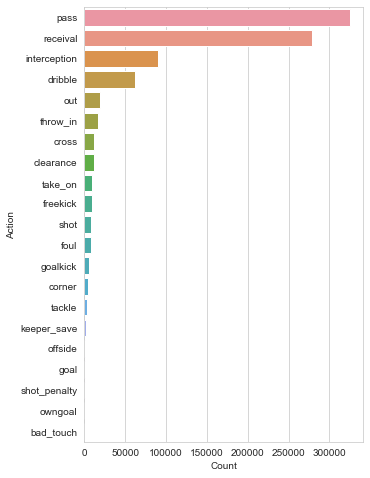

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (5,8))
sns.barplot(data = all_games, x = all_games.Count, y = all_games.index)
plt.ylabel('Action')

In [96]:
all_leagues = pd.read_excel('/Users/leonardoyang/Desktop/stats_campionati.xlsx')
all_leagues = all_leagues.groupby(['League','type_name']).sum().reset_index().sort_values('Count', ascending = False)

In [97]:
all_leagues

,League,type_name,Count
98,Serie A,pass,333239
77,Premier League,pass,325463
56,Ligue 1,pass,316599
35,La Liga,pass,314512
99,Serie A,receival,291652
...,...,...,...
21,La Liga,bad_touch,30
76,Premier League,owngoal,29
63,Premier League,bad_touch,29
13,Bundesliga,owngoal,22


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

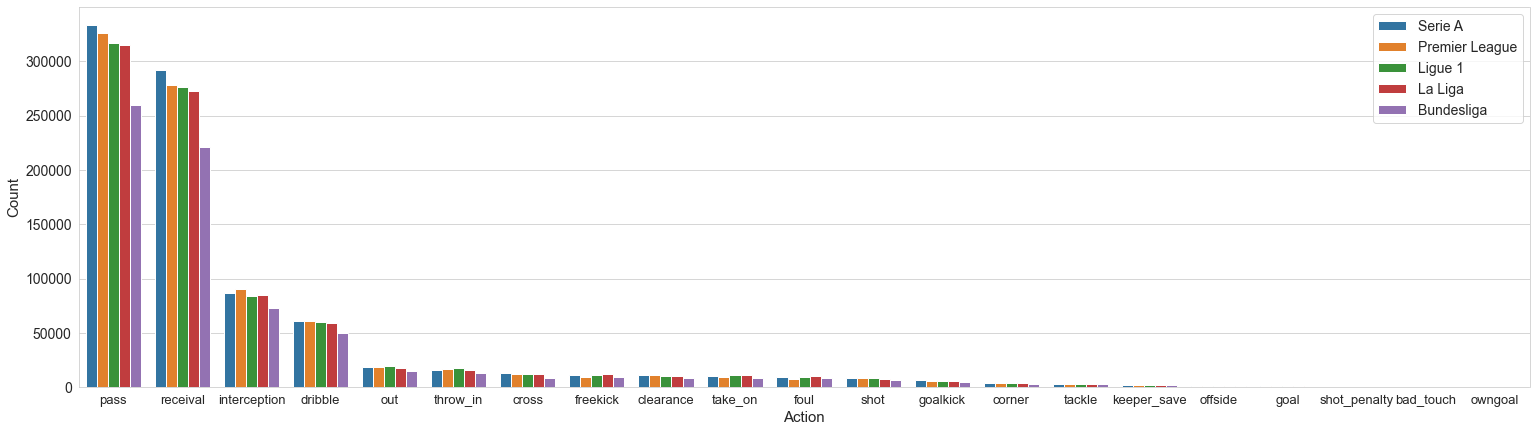

In [117]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (26,7))
sns.barplot(data = all_leagues, x = all_leagues.type_name, y = all_leagues.Count, hue = 'League')
plt.xlabel('Action', fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 13)
plt.legend(fontsize= 14)
plt.yticks(fontsize = 14)

In [120]:
all_leagues.groupby('type_name').sum().sort_values('Count', ascending = False)

,Count
type_name,
pass,1549368
receival,1340197
interception,418972
dribble,292155
out,89497
throw_in,80305
cross,58634
freekick,53716
clearance,53144
